<a href="https://colab.research.google.com/github/fadillarizalul/thesis-alzheimer/blob/main/model_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up dan init

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [ ]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

#import data dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate \
https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true \
  -O 3-classes-alzheimer.zip

--2022-09-13 03:46:44--  https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-13 03:46:44--  https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-13 03:46:45--  https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [ ]:
!unzip /content/3-classes-alzheimer.zip

Archive:  /content/3-classes-alzheimer.zip
   creating: 3-classes-alzheimer-20-patients/
   creating: 3-classes-alzheimer-20-patients/AD/
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00002.jpg  
  inflating: 3-classes

In [ ]:
import os
 #lokasi direktori dasar
dir_base ='/content/3-classes-alzheimer-20-patients'
os.listdir(dir_base)
print(os.listdir(dir_base))

#hitung jumlah file per direktori
data_cn = len(os.listdir('/content/3-classes-alzheimer-20-patients/CN'))
data_mci = len(os.listdir('/content/3-classes-alzheimer-20-patients/MCI')) 
data_ad = len(os.listdir('/content/3-classes-alzheimer-20-patients/AD')) 

print("Amount of CN class images:", data_cn)
print("Amount of MCI class images:", data_mci)
print("Amount of AD class images:", data_ad)

['AD', 'MCI', 'CN']
Amount of CN class images: 101
Amount of MCI class images: 100
Amount of AD class images: 108


In [ ]:
BATCH_SIZE = 32
IMG_SHAPE = 256

## Split into train, test, and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

# First split into train and test sets at 80:20 ratio
# Second split into train validation at 75:25 ratio
# - results in 60:20:20 ratio (train, val, test)
train, test = train_test_split(dir_base, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1)

# Data Generation and Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  # rotation_range=30,
                                  # zoom_range=0.2,
                                  # horizontal_flip=True,
                                  # vertical_flip=True,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale = 1./255
#                                    validation_split = 0.2
                                  )

# test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)
 
val_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

Found 248 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


In [ ]:
# # TRAIN
# image_gen_train = ImageDataGenerator(rescale=1./255., 
#                                      horizontal_flip=True, 
#                                      rotation_range=20, 
#                                      zoom_range=0.2)

# train_generator = image_gen_train.flow_from_directory(
#     train,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [ ]:
# # VALID
# image_gen_val = ImageDataGenerator(rescale=1./255.)

# val_generator = image_gen_val.flow_from_directory(
#     val,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [ ]:
# # TEST
# image_gen_test = ImageDataGenerator(rescale=1./255.)

# test_generator = image_gen_val.flow_from_directory(
#     test,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

# Create CNN model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_tensor=Input(shape=(IMG_SHAPE,IMG_SHAPE,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
base_model.trainable = False

In [ ]:
head = base_model.output

head = MaxPooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)

# head = Dense(128, activation='elu')(head)
# head = Dropout(0.3)(head)

head = Dense(256, activation='elu')(head)
head = Dropout(0.3)(head)

head = Dense(3, activation='softmax')(head)

model = Model(base_model.input, head)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Compile the Model

In [ ]:
# Create optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt = 'adam'
lss = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=opt,
              loss=lss,
              metrics=['accuracy'])

early stopping

In [ ]:
# Earlystopping will stop the learning process when there are no
# ten consecutive improvements in the val_loss.
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min',
                              verbose=1,
                              patience=15)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2)

In [ ]:
history = model.fit(train_generator, 
                    epochs=25, 
                    validation_data=val_generator, 
                    )

Epoch 1/25
8/8 [==============================] - 68s 8s/step - loss: 10.6330 - accuracy: 0.3185 - val_loss: 3.4619 - val_accuracy: 0.3279
Epoch 2/25
8/8 [==============================] - 61s 8s/step - loss: 2.8089 - accuracy: 0.3790 - val_loss: 3.7108 - val_accuracy: 0.3443
Epoch 3/25
8/8 [==============================] - 63s 8s/step - loss: 2.3225 - accuracy: 0.3629 - val_loss: 1.6760 - val_accuracy: 0.3279
Epoch 4/25
8/8 [==============================] - 61s 8s/step - loss: 1.5843 - accuracy: 0.3427 - val_loss: 1.3467 - val_accuracy: 0.2459
Epoch 5/25
8/8 [==============================] - 61s 8s/step - loss: 1.3774 - accuracy: 0.4274 - val_loss: 1.1962 - val_accuracy: 0.2787
Epoch 6/25
8/8 [==============================] - 63s 8s/step - loss: 1.3175 - accuracy: 0.3468 - val_loss: 1.2187 - val_accuracy: 0.1311
Epoch 7/25
8/8 [==============================] - 61s 8s/step - loss: 1.2275 - accuracy: 0.3669 - val_loss: 1.2206 - val_accuracy: 0.2131
Epoch 8/25
8/8 [=================

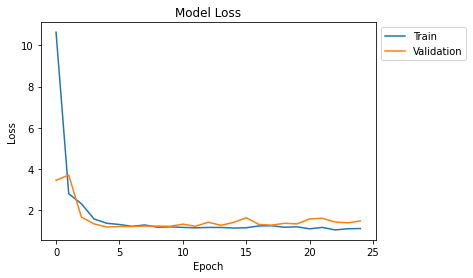

In [ ]:
# Summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

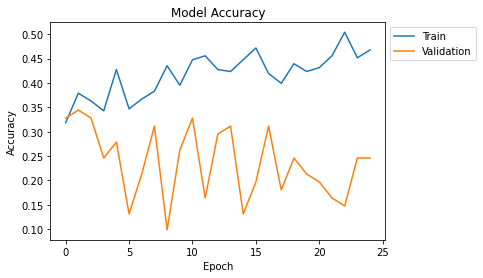

In [ ]:
# Summarize history for loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()